In [1]:
#import some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import matplotlib.image as mpimg
%matplotlib inline

#image manipulation packages
import cv2
import os
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

#Classification
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

sns.set()
#import keras
from tensorflow import keras

import glob
import cv2
import shutil
import random
import Augmentor

# Define YOUR path for the data here!

In [2]:
path = r'C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spring Semester\Deep\Deep_Learning_Project\DatasetPartial-Agreement-Images'
path_txt = r'C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spring Semester\Deep\Deep_Learning_Project\Dataset/PA-expert-annotations.txt'

In [3]:
def image_cnn_model():
    '''creates an image classification model that uses 2 Convolutional CNNs layers (with maxpooling) and feeds the data through
    a dense connected layer. This is trial and error there is no specific reason for 2 layers'''
    cnn_model = keras.Sequential([

        #convolutional layer with 24 3x3 filters - again, arbitrary,
        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'), 

        #MaxPooling - takes the max value of each 2x2 pool in the feature map
        keras.layers.MaxPool2D(pool_size=(3,3)),

        #second convolution with 36 filters
        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation= 'relu'),
    
        #Second MaxPool2D - to check with other options
        keras.layers.MaxPool2D(pool_size=(2,2)),
        
        #the result of kthe CNN is then flattened and placed into the 
        keras.layers.Flatten(),
        
        keras.layers.Dense(128, activation='relu'),
        
        #keras.layers.Dense(256, activation='relu'),
        
        #final layer, is output, 1 out of 5 possible results
        #0 Normal, 1 Tapered, 2 Pyriform, 3 Small, 5 Amorphous
        keras.layers.Dense(5, activation='softmax')
    ])
    
    return cnn_model

In [4]:
#1 - load txt file
sperm = 'Sperm'
dataframe = pd.read_csv(path_txt, sep = '\\t', header = None)
dataframe

<ipython-input-4-0d1d7ad445a4>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataframe = pd.read_csv(path_txt, sep = '\\t', header = None)


,0,1,2,3,4
0,p1-pl2-sample01/Sperm_01,5,5,5,5
1,p1-pl2-sample01/Sperm_02,1,5,5,5
2,p1-pl2-sample01/Sperm_03,0,0,0,0
3,p1-pl2-sample01/Sperm_04,1,5,5,5
4,p1-pl2-sample01/Sperm_05,0,0,0,0
...,...,...,...,...,...
1127,p5-pl1-sample20/Sperm_07,1,5,5,5
1128,p5-pl1-sample20/Sperm_09,1,1,5,1
1129,p5-pl1-sample20/Sperm_11,1,1,5,1
1130,p5-pl1-sample20/Sperm_12,5,5,5,5


In [5]:
#editions to target dataset
dataframe.rename(columns={0 :"Sperm_Pic", 1: 'Expert_1', 2: 'Expert_2', 3: 'Expert_3', 4: 'Majority_Vote'}, inplace = True)
dataframe['Sperm_Pic'] = dataframe['Sperm_Pic'].str.replace('/S', '-s')
dataframe['Majority_Vote'] = dataframe['Majority_Vote'].replace(5, 4)


#add ch_00 to all rows:
dataframe['Sperm_Pic'] = 'ch00_' + dataframe['Sperm_Pic'] + '.tif'

#Drop all irrelevant features
dataframe = dataframe.drop(['Expert_1', 'Expert_2', 'Expert_3'], axis = 1)

#Show
dataframe

,Sperm_Pic,Majority_Vote
0,ch00_p1-pl2-sample01-sperm_01.tif,4
1,ch00_p1-pl2-sample01-sperm_02.tif,4
2,ch00_p1-pl2-sample01-sperm_03.tif,0
3,ch00_p1-pl2-sample01-sperm_04.tif,4
4,ch00_p1-pl2-sample01-sperm_05.tif,0
...,...,...
1127,ch00_p5-pl1-sample20-sperm_07.tif,4
1128,ch00_p5-pl1-sample20-sperm_09.tif,1
1129,ch00_p5-pl1-sample20-sperm_11.tif,1
1130,ch00_p5-pl1-sample20-sperm_12.tif,4


In [6]:
dataframe['Majority_Vote'].value_counts()

4    656
1    228
0    100
2     76
3     72
Name: Majority_Vote, dtype: int64

In [7]:
#labels in array
labels = np.array(dataframe['Majority_Vote'])
labels = np.array(np.split(labels, 1132))

In [8]:
dataframe

,Sperm_Pic,Majority_Vote
0,ch00_p1-pl2-sample01-sperm_01.tif,4
1,ch00_p1-pl2-sample01-sperm_02.tif,4
2,ch00_p1-pl2-sample01-sperm_03.tif,0
3,ch00_p1-pl2-sample01-sperm_04.tif,4
4,ch00_p1-pl2-sample01-sperm_05.tif,0
...,...,...
1127,ch00_p5-pl1-sample20-sperm_07.tif,4
1128,ch00_p5-pl1-sample20-sperm_09.tif,1
1129,ch00_p5-pl1-sample20-sperm_11.tif,1
1130,ch00_p5-pl1-sample20-sperm_12.tif,4


# Preprocessing: Divides Dataset in Folders by Class

In [9]:
imgs = []

for image in glob.glob(path+'\*.tif'):
        
    imgs.append(cv2.imread(image))

    #names of each sample in the image and dataframe are different, gotta deal with this here to match them

    img_name = image.split('/')[-1]
    check_length = img_name.split('-')[-2]
    if len(check_length) == 7:
        img_name = img_name[:18] + '0' + img_name[18:]
    check_length = img_name.split('-')[-1]
    if len(check_length) == 10:
        img_name = img_name[:-5] + '0' + img_name[-5:]
    img_name = img_name[:-6] + '_' + img_name[-6:]
    
    #path of each class
    path0 = path+'/class0'
    path1 = path+'/class1'
    path2 = path+'/class2'
    path3 = path+'/class3'
    path4 = path+'/class4'
    
    #creates folders to store images from eacg category, if not exists already
    if not os.path.isdir(path0):
        path = path4
        os.mkdir(path)
        path = path3
        os.mkdir(path)
        path = path2
        os.mkdir(path)
        path = path1
        os.mkdir(path)
        path = path0
        os.mkdir(path)
    
    maj_vote = dataframe[dataframe['Sperm_Pic'].str.contains(img_name)]['Majority_Vote']
    if maj_vote.values == 4:
        shutil.copy(image, path4)
    if maj_vote.values == 3:
        shutil.copy(image, path3)
    if maj_vote.values == 2:
        shutil.copy(image, path2)
    if maj_vote.values == 1:
        shutil.copy(image, path1)
    if maj_vote.values == 0:
        shutil.copy(image, path0)
        

# Preprocessing: Divides Dataset in Training, Validation and Test Folders

In [10]:
classes_dir = ['/class0', '/class1', '/class2', '/class3', '/class4']

val_ratio = 0.2
test_ratio = 0.2

if not os.path.isdir(path + '/train'):

    for cls in classes_dir:
    
        #creates train and test folders, with each class separated inside
        os.makedirs(path +'/train' + cls)
        os.makedirs(path +'/val' + cls)
        os.makedirs(path +'/test' + cls)


        # Creating partitions of the data after shuffeling
        src = path + cls # Folder to copy images from

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio - test_ratio)), 
                                                               int(len(allFileNames)* (1 - val_ratio))])
        
        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    
        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, path +'/train' + cls)

        for name in val_FileNames:
            shutil.copy(name, path +'/val' + cls)

        for name in test_FileNames:
            shutil.copy(name, path +'/test' + cls)
        

# Data Augmentation

In [11]:
# Define augmentation pipelines
class_0 = Augmentor.Pipeline(path+'/train/class0')
class_1 = Augmentor.Pipeline(path+'/train/class1')
class_2 = Augmentor.Pipeline(path+'/train/class2')
class_3 = Augmentor.Pipeline(path+'/train/class3')

# Define different augmentations depending on the pipeline; options are limited since we're working with microscopy data

#visit: https://augmentor.readthedocs.io/en/master/userguide/mainfeatures.html#rotating
#options are:
#Perspective skewing: does not make sense; microscopy data
###Elastic distortion: could work, but I'm afraid it'll actually deform the shape of the sper cell, which is what is picked up to classify it; could be detremental...
###Rotation: makes sense! But no more than 5 degrees left or right...
#Shear: does not make sense?
#Cropping: does not make sense.
###Mirroring: yes! both vertically and horizontally, randomly.


#rotate by a maximum of 5 degrees
class_0.rotate(probability=0.7, max_left_rotation=5, max_right_rotation=5)
class_1.rotate(probability=0.7, max_left_rotation=5, max_right_rotation=5)
class_2.rotate(probability=0.7, max_left_rotation=5, max_right_rotation=5)
class_3.rotate(probability=0.7, max_left_rotation=5, max_right_rotation=5)

#mirroring, vertical or horizontal, randomly
class_0.flip_random(probability=0.7)
class_1.flip_random(probability=0.7)
class_2.flip_random(probability=0.7)
class_3.flip_random(probability=0.7)

# Augment images to the same proportion as existing ones in class 4 (majority class)
class_0.sample(393-60)
class_1.sample(394-136)
class_2.sample(394-45)
class_3.sample(394-43)

Initialised with 0 image(s) found.
Output directory set to C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spring Semester\Deep\Deep_Learning_Project\DatasetPartial-Agreement-Images/train/class0\output.

OSError: The source directory you specified does not exist.

In [348]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 5, #rotates images from -5 to 5 degrees
                                   width_shift_range = 0.06, #translates images by 6% to left or right
                                   height_shift_range = 0.06, #translates images by 6% up and down
                                   vertical_flip = True,
                                   horizontal_flip = True,
                                   brightness_range=[0.2,1.2]) #darkens or brightens the images anywhere between 0 and 20%
                                   #shear_range = 0.2, #doesn't make sense here
                                   #zoom_range = 0.2 #does not make sense coz this is microscopy data, all taken with same magnification


val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(path+'/train',
                                                 target_size = (35, 35),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

val_set = test_datagen.flow_from_directory(path+'/val',
                                            target_size = (35, 35),
                                            batch_size = 32,
                                            class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(path+'/test',
                                            target_size = (35, 35),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1968 images belonging to 5 classes.
Found 226 images belonging to 5 classes.
Found 229 images belonging to 5 classes.


In [338]:
#def load_images_from_folder(folder):
    #images = []
    #for filename in os.listdir(folder):
        #if filename.endswith(".tif"):
            #img = cv2.imread(os.path.join(folder, filename))
            #if img is not None:
                #img=np.array(img)
                #img = img.astype('float32')
                #img /= 255
                #images.append(img)
    #return images

#root_folder = path + '/train'
#folders = [os.path.join(root_folder, x) for x in ('class0', 'class1', 'class2', 'class3', 'class4')]
#all_train_images = [img for folder in folders for img in load_images_from_folder(folder)]


SyntaxError: invalid syntax (<ipython-input-344-dd8b477d1170>, line 1)

In [339]:
training_set.class_indices

{'class0': 0, 'class1': 1, 'class2': 2, 'class3': 3, 'class4': 4}

In [369]:
cnn_model = image_cnn_model()

cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping criteria
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights = True)
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [370]:
# if you have the latest version of tensorflow, the fit_generator is deprecated.
# you should use the fit method (i.e., hist=classifier.fit).
# if you do not have the last version you must use fit_generator
hist=cnn_model.fit_generator(training_set,
                         steps_per_epoch = len(training_set)//32,
                         epochs = 50,
                         validation_data = val_set,
                         validation_steps = len(val_set)//32)   

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
1/1 [==============================] - 1s 770ms/step - loss: 1.6087 - accuracy: 0.2500
Epoch 2/50
1/1 [==============================] - 0s 161ms/step - loss: 1.6614 - accuracy: 0.1875
Epoch 3/50
1/1 [==============================] - 0s 155ms/step - loss: 1.7041 - accuracy: 0.1562
Epoch 4/50
1/1 [==============================] - 0s 133ms/step - loss: 1.5681 - accuracy: 0.3438
Epoch 5/50
1/1 [==============================] - 0s 146ms/step - loss: 1.6288 - accuracy: 0.1562
Epoch 6/50
1/1 [==============================] - 0s 126ms/step - loss: 1.6668 - accuracy: 0.1562
Epoch 7/50
1/1 [==============================] - 0s 130ms/step - loss: 1.6442 - accuracy: 0.0625
Epoch 8/50
1/1 [==============================] - 0s 120ms/step - loss: 1.6046 - accuracy: 0.2812
Epoch 9/50
1/1 [==============================] - 0s 124ms/step - loss: 1.5974 - accuracy: 0.1562
Epoch 10/50
1/1 [==============================] - 0s 126ms/step - loss: 1.5985 - accuracy: 0.2500
Epoch 11/50
1/1 [==

In [372]:
# if you have the last version of tensorflow, the predict_generator is deprecated.
# you should use the predict method.
# if you do not have the last version, you must use predict_generator
Y_pred = cnn_model.predict_generator(test_set, 8) # ceil(num_of_test_samples / batch_size)

Y = []

for sperm_cell in Y_pred:
    Y.append(list(sperm_cell).index(max(sperm_cell)))

#Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(multilabel_confusion_matrix(test_set.classes, Y))
print('Classification Report')
target_names = ['0', '1', '2', '3', '4']
print(classification_report(test_set.classes, Y, target_names=target_names))

Confusion Matrix
[[[ 26 183]
  [  4  16]]

 [[157  26]
  [ 43   3]]

 [[213   0]
  [ 16   0]]

 [[214   0]
  [ 15   0]]

 [[ 96   1]
  [132   0]]]
Classification Report
              precision    recall  f1-score   support

           0       0.08      0.80      0.15        20
           1       0.10      0.07      0.08        46
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00       132

    accuracy                           0.08       229
   macro avg       0.04      0.17      0.05       229
weighted avg       0.03      0.08      0.03       229



In [309]:
Y

[1,
 4,
 4,
 1,
 1,
 2,
 4,
 1,
 4,
 1,
 0,
 3,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 3,
 1,
 4,
 1,
 4,
 3,
 1,
 4,
 0,
 1,
 3,
 0,
 0,
 0,
 4,
 3,
 1,
 1,
 0,
 4,
 4,
 3,
 0,
 4,
 2,
 0,
 4,
 1,
 3,
 4,
 2,
 4,
 0,
 1,
 1,
 2,
 2,
 3,
 0,
 2,
 0,
 1,
 1,
 1,
 4,
 3,
 1,
 0,
 1,
 3,
 4,
 1,
 2,
 1,
 0,
 4,
 0,
 0,
 1,
 0,
 0,
 4,
 4,
 0,
 0,
 3,
 3,
 3,
 2,
 1,
 1,
 1,
 3,
 1,
 0,
 1,
 4,
 0,
 4,
 2,
 4,
 4,
 3,
 1,
 0,
 4,
 4,
 1,
 4,
 0,
 2,
 3,
 1,
 1,
 2,
 3,
 2,
 3,
 2,
 0,
 0,
 3,
 0,
 4,
 4,
 0,
 0,
 1,
 0,
 4,
 1,
 3,
 4,
 4,
 2,
 4,
 4,
 4,
 2,
 3,
 4,
 1,
 3,
 1,
 1,
 1,
 1,
 0,
 4,
 1,
 0,
 4,
 4,
 1,
 2,
 1,
 4,
 2,
 1,
 4,
 1,
 2,
 1,
 2,
 2,
 0,
 0,
 4,
 1,
 3,
 0,
 4,
 4,
 3,
 0,
 1,
 1,
 0,
 1,
 1,
 4,
 2,
 0,
 3,
 0,
 4,
 4,
 1,
 1,
 1,
 0,
 3,
 3,
 4,
 1,
 3,
 2,
 3,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 1,
 0,
 4,
 1,
 1,
 2,
 4,
 1,
 4,
 3,
 4,
 0,
 0,
 2,
 2,
 3,
 3,
 4,
 3,
 0,
 2,
 4,
 3,
 1]

In [300]:
test_set.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

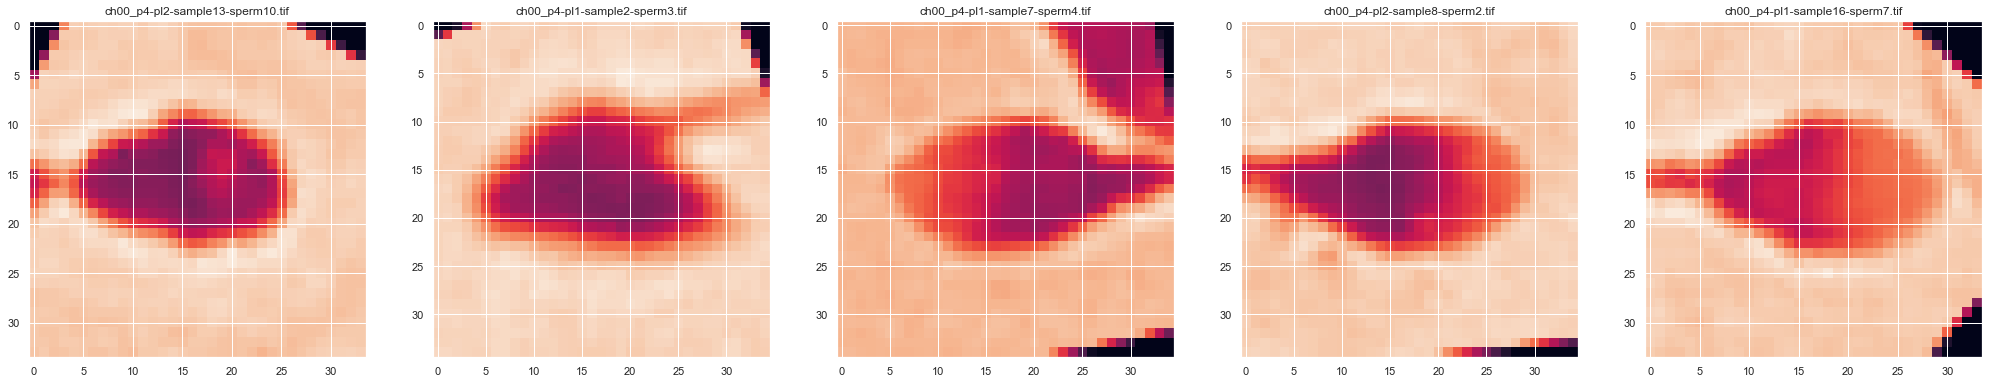

In [155]:
#Small test to print last 5 pics

plt.figure(figsize=(35,35))

#test_folder=r'C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spring Semester\Deep\SCIAN-MorphoSpermGS\Partial-Agreement-Images'
test_folder = r'/Users/Daniel/Documents/DL_Project/Datasets/SCIAN-MorphoSpermGS/Partial-Agreement-Images'
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [156]:
def create_dataset(img_folder):
   
    img_data_array=[]
    
    for file in os.listdir(os.path.join(img_folder)):
        
        image_path= os.path.join(img_folder, file)
        image= cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, (35, 35))#, interpolation = cv2.INTER_AREA) #why interpolate? our images are already 35x35, no need to resize
        image=np.array(image)
        image = image.astype('float32')
        image /= 255 
        img_data_array.append(image)
    
    return img_data_array #extract the image array and class name
img_data = create_dataset(test_folder)
img_data

error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-39p1qqfs/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


NameError: name 'train_test_valid_split' is not defined

In [ ]:
#1. augmentation while dealing w class imbalance
#4. callback for ealy stopping, modelcheckpoint and LearningRateScheduler - https://colab.research.google.com/github/mr7495/covid19/blob/master/data_Loading_Training_Evaluating.ipynb#scrollTo=2Gx5rM25d4W4
#2. all pipeline for 5fold cv and metrics/plots for metrics (including learning curves and losses)
#3. Add dropout layer
#3. Copy CNN structure of paper(s)
#5. saliency maps
#6. app?

